In [0]:
import tensorflow as tf
import numpy as np
from utils import load_data, train_dev_test, make_map_from_nested, word_vectors, trigram_vectors, all_vectors
from sklearn.preprocessing import LabelEncoder

In [0]:
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Input, Dense, Dropout, Flatten, Concatenate, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
seed = 42
database, top_tokens = load_data('data')

In [7]:
database.head()

,username,text,class
0,Porter,музыка человек какой музыка слушать русский ро...,Music
1,John Doe,тат дим билан фабрика корень рефлекс рука вверх,Music
2,AlexTV,электронный музыка,Music
3,Zeke,практически самый джон тимоти самый дело любит...,Music
4,Morchant,данный момент слушать офигительный,Music


In [0]:
classes = list(set(database['class']))
classes.sort()

In [0]:
train, dev, test = train_dev_test(database, seed)

In [0]:
class_map = {classes[idx]:idx for idx in range(len(classes))}  # class mapping to integers
word_map = make_map_from_nested(top_tokens['top_words'].values())
trigram_map = make_map_from_nested(top_tokens['top_trigrams'].values())

In [0]:
y_train_ints = np.array([class_map[label] for label in train['class']])
y_dev_ints = np.array([class_map[label] for label in dev['class']])
y_test_ints = np.array([class_map[label] for label in test['class']])

In [0]:
y_train = to_categorical(y_train_ints, 10)
y_dev = to_categorical(y_dev_ints, 10)
y_test = to_categorical(y_test_ints, 10)

In [0]:
results = set()
for sen in train['text']:
    results.update(sen.split())
all_map = {w:i for i, w in enumerate(list(results))}

In [0]:
X_train_words = word_vectors(train['text'], word_map)
X_train_trigrams = trigram_vectors(train['text'], trigram_map)
X_train_all = all_vectors(train['text'], all_map)
X_dev_words = word_vectors(dev['text'], word_map)
X_dev_trigrams = trigram_vectors(dev['text'], trigram_map)
X_dev_all = all_vectors(dev['text'], all_map)
X_test_words = word_vectors(test['text'], word_map)
X_test_trigrams = trigram_vectors(test['text'], trigram_map)
X_test_all = all_vectors(test['text'], all_map)

In [0]:
max_word_len = max(max([len(s) for s in X_train_words]),
                   max([len(s) for s in X_dev_words]),
                   max([len(s) for s in X_test_words]))
max_tri_len = max(max([len(s) for s in X_train_trigrams]),
                  max([len(s) for s in X_dev_trigrams]),
                  max([len(s) for s in X_test_trigrams]))
max_all_len = 350

In [0]:
X_train_w = pad_sequences(X_train_words, max_word_len, padding='post')
X_train_t = pad_sequences(X_train_trigrams, max_tri_len, padding='post')
X_train_a = pad_sequences(X_train_all, max_all_len, padding='post')
X_dev_w = pad_sequences(X_dev_words, max_word_len, padding='post')
X_dev_t = pad_sequences(X_dev_trigrams, max_tri_len, padding='post')
X_dev_a = pad_sequences(X_dev_all, max_all_len, padding='post')
X_test_w = pad_sequences(X_test_words, max_word_len, padding='post')
X_test_t = pad_sequences(X_test_trigrams, max_tri_len, padding='post')
X_test_a = pad_sequences(X_test_all, max_all_len, padding='post')

X_train_w = np.expand_dims(X_train_t, axis=2)
X_dev_w = np.expand_dims(X_dev_t, axis=2)
X_test_w = np.expand_dims(X_test_t, axis=2)
X_train_t = np.expand_dims(X_train_t, axis=2)
X_dev_t = np.expand_dims(X_dev_t, axis=2)
X_test_t = np.expand_dims(X_test_t, axis=2)

In [0]:
def build_model(word_vocab_size,
                word_embedding_size,
                word_input_length,
                trigram_vocab_size,
                trigram_embedding_size,
                trigram_input_length,
                all_vocab_size,
                all_embedding_size,
                all_input_length,
                dropout_rate,
                num_classes):
    word_input = Input(shape=(word_input_length,))
    trigram_input = Input(shape=(trigram_input_length,))
    all_input = Input(shape=(all_input_length,))

    word_embedding = Embedding(input_dim=word_vocab_size,
                               output_dim=word_embedding_size,
                               input_length=word_input_length,
                               trainable=True)(word_input)
    x1 = Conv1D(26, 5, activation='relu')(word_embedding)
    x1 = MaxPooling1D(2)(x1)
    x1 = Flatten()(x1)
    x1 = BatchNormalization(trainable=True)(x1)
    x1 = Dropout(dropout_rate)(x1)
    x1 = Model(inputs=word_input, outputs=x1)

    trigram_embedding = Embedding(input_dim=trigram_vocab_size,
                               output_dim=trigram_embedding_size,
                               input_length=trigram_input_length,
                               trainable=True)(trigram_input)
    x2 = Conv1D(26, 5, activation='relu')(trigram_embedding)
    x2 = MaxPooling1D(2)(x2)
    x2 = Flatten()(x2)
    x2 = BatchNormalization(trainable=True)(x2)
    x2 = Dropout(dropout_rate)(x2)
    x2 = Model(inputs=trigram_input, outputs=x2)

    all_embedding = Embedding(input_dim=all_vocab_size,
                              output_dim=all_embedding_size,
                              input_length=all_input_length,
                              trainable=True)(all_input)
    x3 = Conv1D(52, 10, activation='relu')(all_embedding)
    x3 = MaxPooling1D(4)(x3)
    x3 = Flatten()(x3)
    x3 = BatchNormalization(trainable=True)(x3)
    x3 = Dropout(dropout_rate)(x3)
    x3 = Model(inputs=all_input, outputs=x3)

    combined = Concatenate()([x1.output, x2.output, x3.output])
    z = Dense(512, activation='relu')(combined)
    z = BatchNormalization(trainable=True)(z)
    z = Dropout(dropout_rate)(z)
    z = Dense(256, activation='relu')(z)
    z = BatchNormalization(trainable=True)(z)
    z = Dropout(dropout_rate)(z)
    z = Dense(num_classes, activation='softmax')(z)

    model = Model(inputs=[x1.input, x2.input, x3.input], outputs=z)

    return model

In [0]:
word_vocab_size = len(word_map) + 1  # Adding 1 because of reserved 0 index
word_embedding_size = 200
trigram_vocab_size = len(trigram_map) + 1
trigram_embedding_size = 100
all_vocab_size = len(all_map) + 1
all_embedding_size = 400
dropout_rate = 0.5
batch_size = 512
epochs = 100
num_classes = 10

In [0]:
model = build_model(word_vocab_size, word_embedding_size, max_word_len,
                    trigram_vocab_size, trigram_embedding_size, max_tri_len,
                    all_vocab_size, all_embedding_size, max_all_len,
                    dropout_rate, num_classes)

In [0]:
earlystop = EarlyStopping(monitor='val_loss', patience=2)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [21]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 385)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 614)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 385, 200)     218000      input_1[0][0]                    
____________________________________________________________________________________________

In [22]:
history=model.fit([X_train_w, X_train_t, X_train_a], y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks = [earlystop, mc],
          verbose=1,
          validation_data=([X_dev_w, X_dev_t, X_dev_a], y_dev))

Epoch 1/100
419/419 [==============================] - 298s 711ms/step - loss: 0.9638 - accuracy: 0.7096 - val_loss: 0.9318 - val_accuracy: 0.7132
Epoch 2/100
419/419 [==============================] - 292s 697ms/step - loss: 0.3434 - accuracy: 0.8959 - val_loss: 1.8208 - val_accuracy: 0.6308
Epoch 3/100
419/419 [==============================] - 295s 703ms/step - loss: 0.2109 - accuracy: 0.9367 - val_loss: 0.4688 - val_accuracy: 0.8630
Epoch 4/100
419/419 [==============================] - 292s 697ms/step - loss: 0.1567 - accuracy: 0.9520 - val_loss: 0.9222 - val_accuracy: 0.7178
Epoch 5/100
419/419 [==============================] - 292s 698ms/step - loss: 0.1249 - accuracy: 0.9616 - val_loss: 0.7523 - val_accuracy: 0.7841


In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

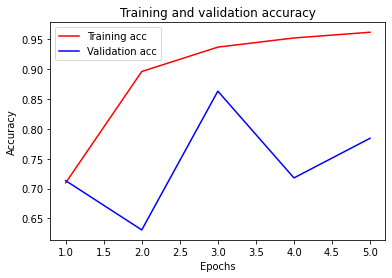

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

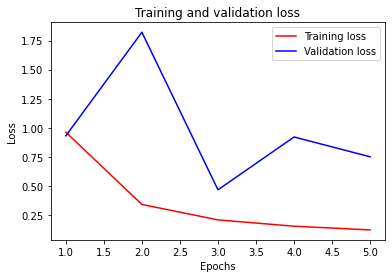

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [27]:
score = model.evaluate([X_test_w, X_test_t, X_test_a], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.762759804725647
Test accuracy: 0.7836861610412598
